# Simulation study for the Functional CLT for TDA on graphs

We illustrate the functional CLT at hand of two prototypical examples, namely the [Gilbert graph](https://projecteuclid.org/euclid.aoms/1177706098) and the [Directed spanning tree](https://projecteuclid.org/euclid.aoap/1171377186).


For the simulation study, we rely on a Poisson point process with intensity 2 in a $15 \times 5$ observation window.

In [1]:
rm(list = ls())

library(ggplot2)
library(spatstat)
library(TDA)

Loading required package: spatstat.data

Loading required package: nlme

Loading required package: rpart


spatstat 1.62-2       (nickname: ‘Shape-shifting lizard’) 
For an introduction to spatstat, type ‘beginner’ 



Note: spatstat version 1.62-2 is out of date by more than 3 months; we recommend upgrading to the latest version.



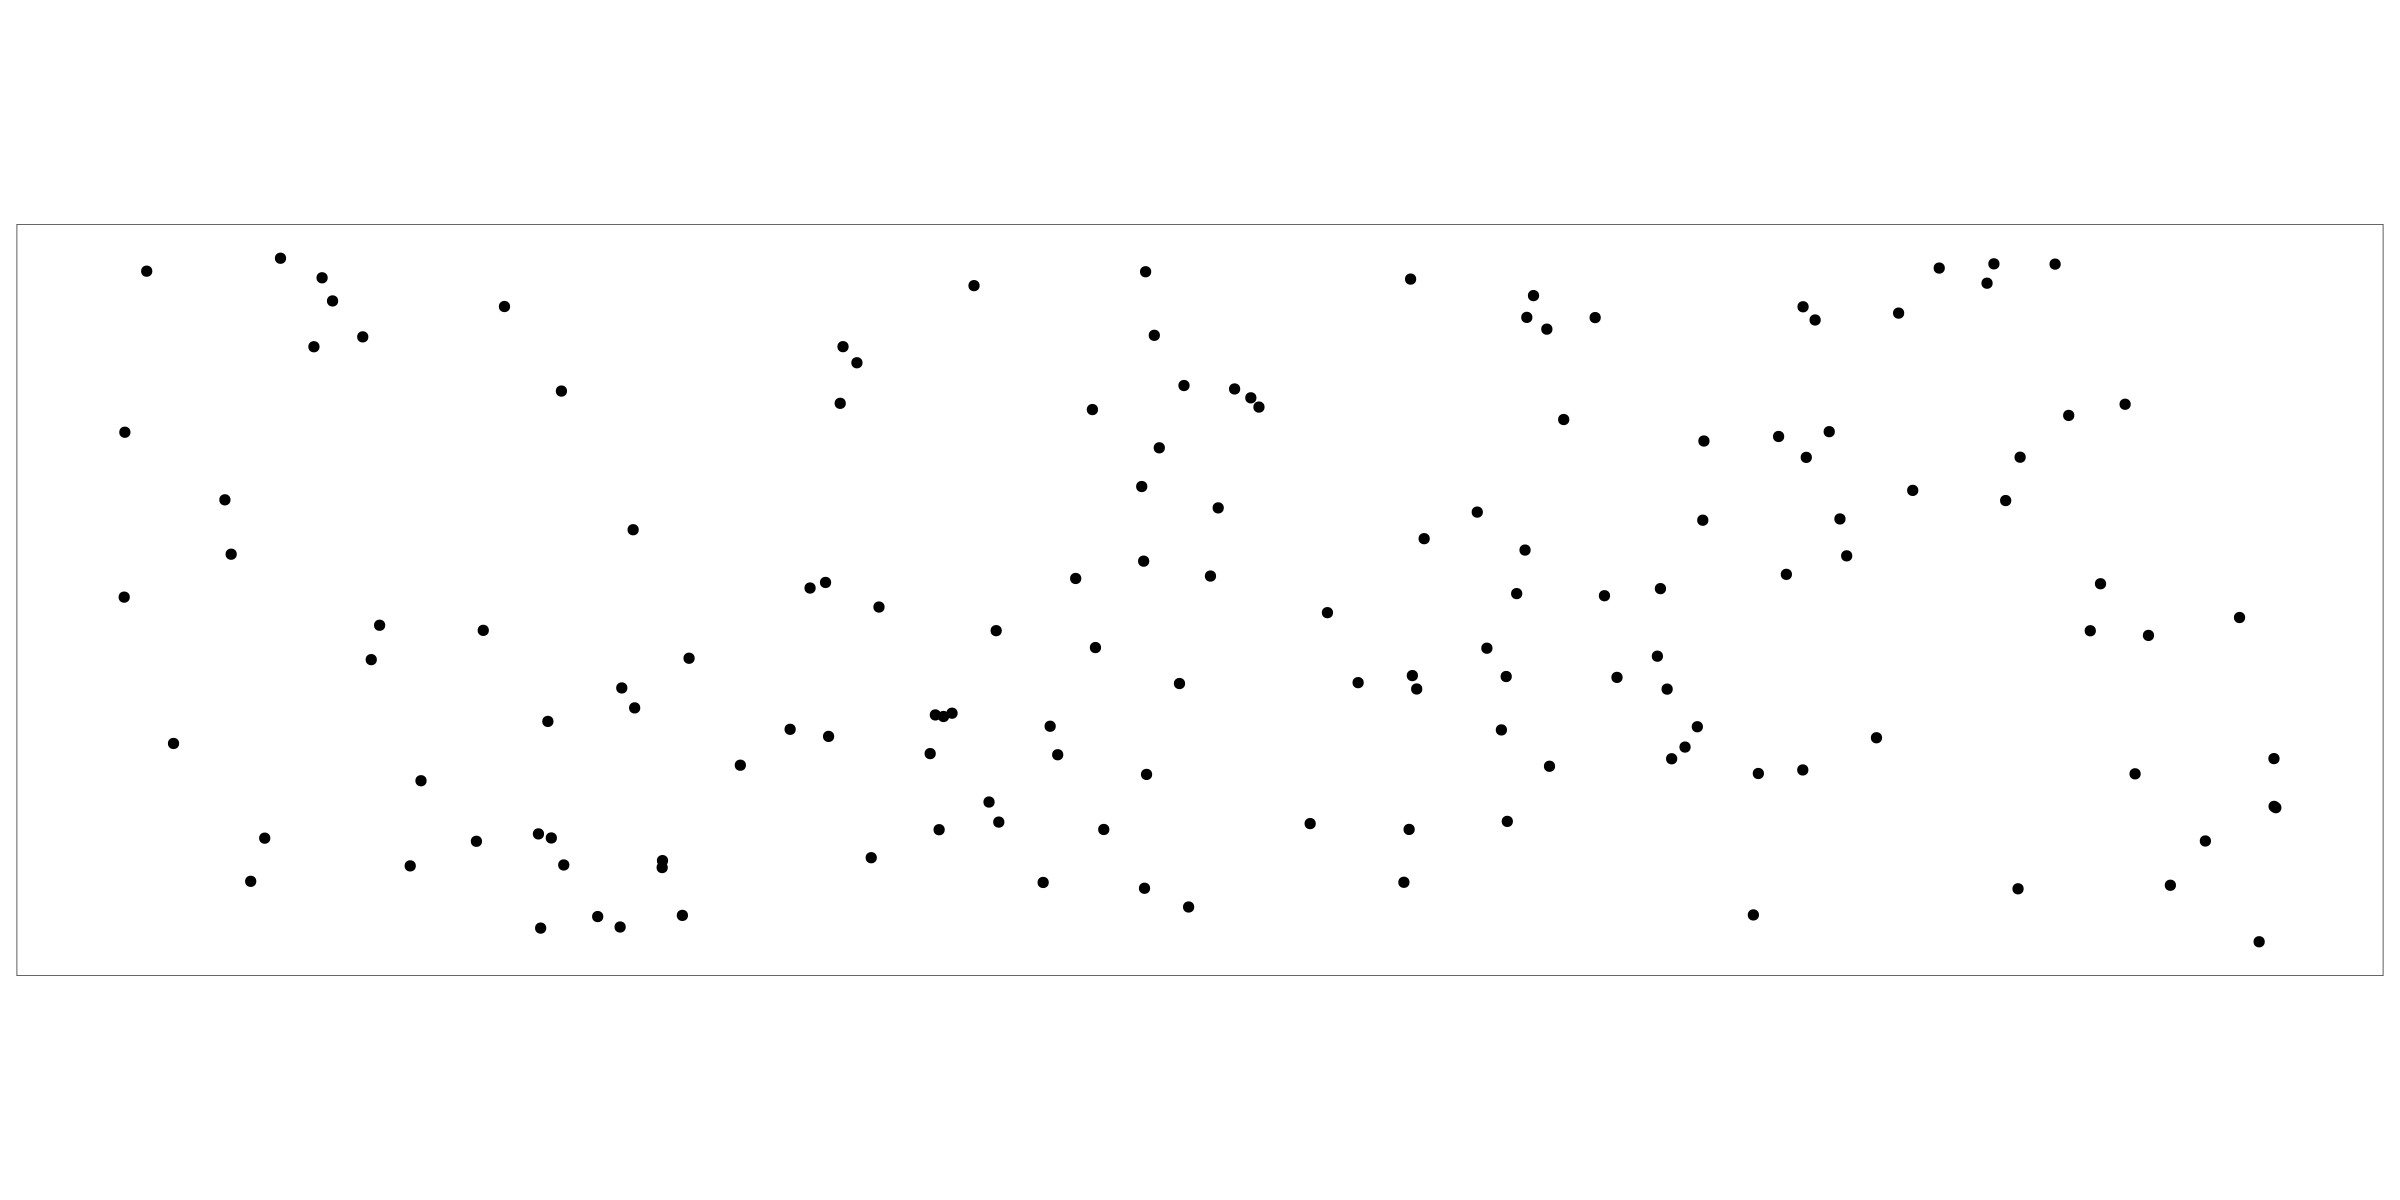

In [2]:
seed <- 1
set.seed(seed)

width = 20
height = 10
options(repr.plot.width = width, 
        repr.plot.height = height)

#number of samples
nsim <- 1e3

win = owin(c(0,15), c(0,5))

ppps <- rpoispp(2, 
                    win = win, 
                    nsim = nsim)

ppp <- ppps[[1]]
qplot(x = ppp$x,  
      y = ppp$y, 
      size = I(2.5)) + 
        theme_void() +
        theme(plot.margin = margin(10, 10, 10, 10)) +
        coord_fixed() +
        theme(panel.border = element_rect(fill = NA))

## Gilbert graph

First, we start by discussing the results for the Gilbert graph. This corresponds to the standard choice of using the Čech complex for growing disks. To begin with, we take one realization andaillustrate the persistence diagrams for 0- and 1-dimensional features. 

Warning message:
“Removed 3 rows containing missing values (geom_point).”


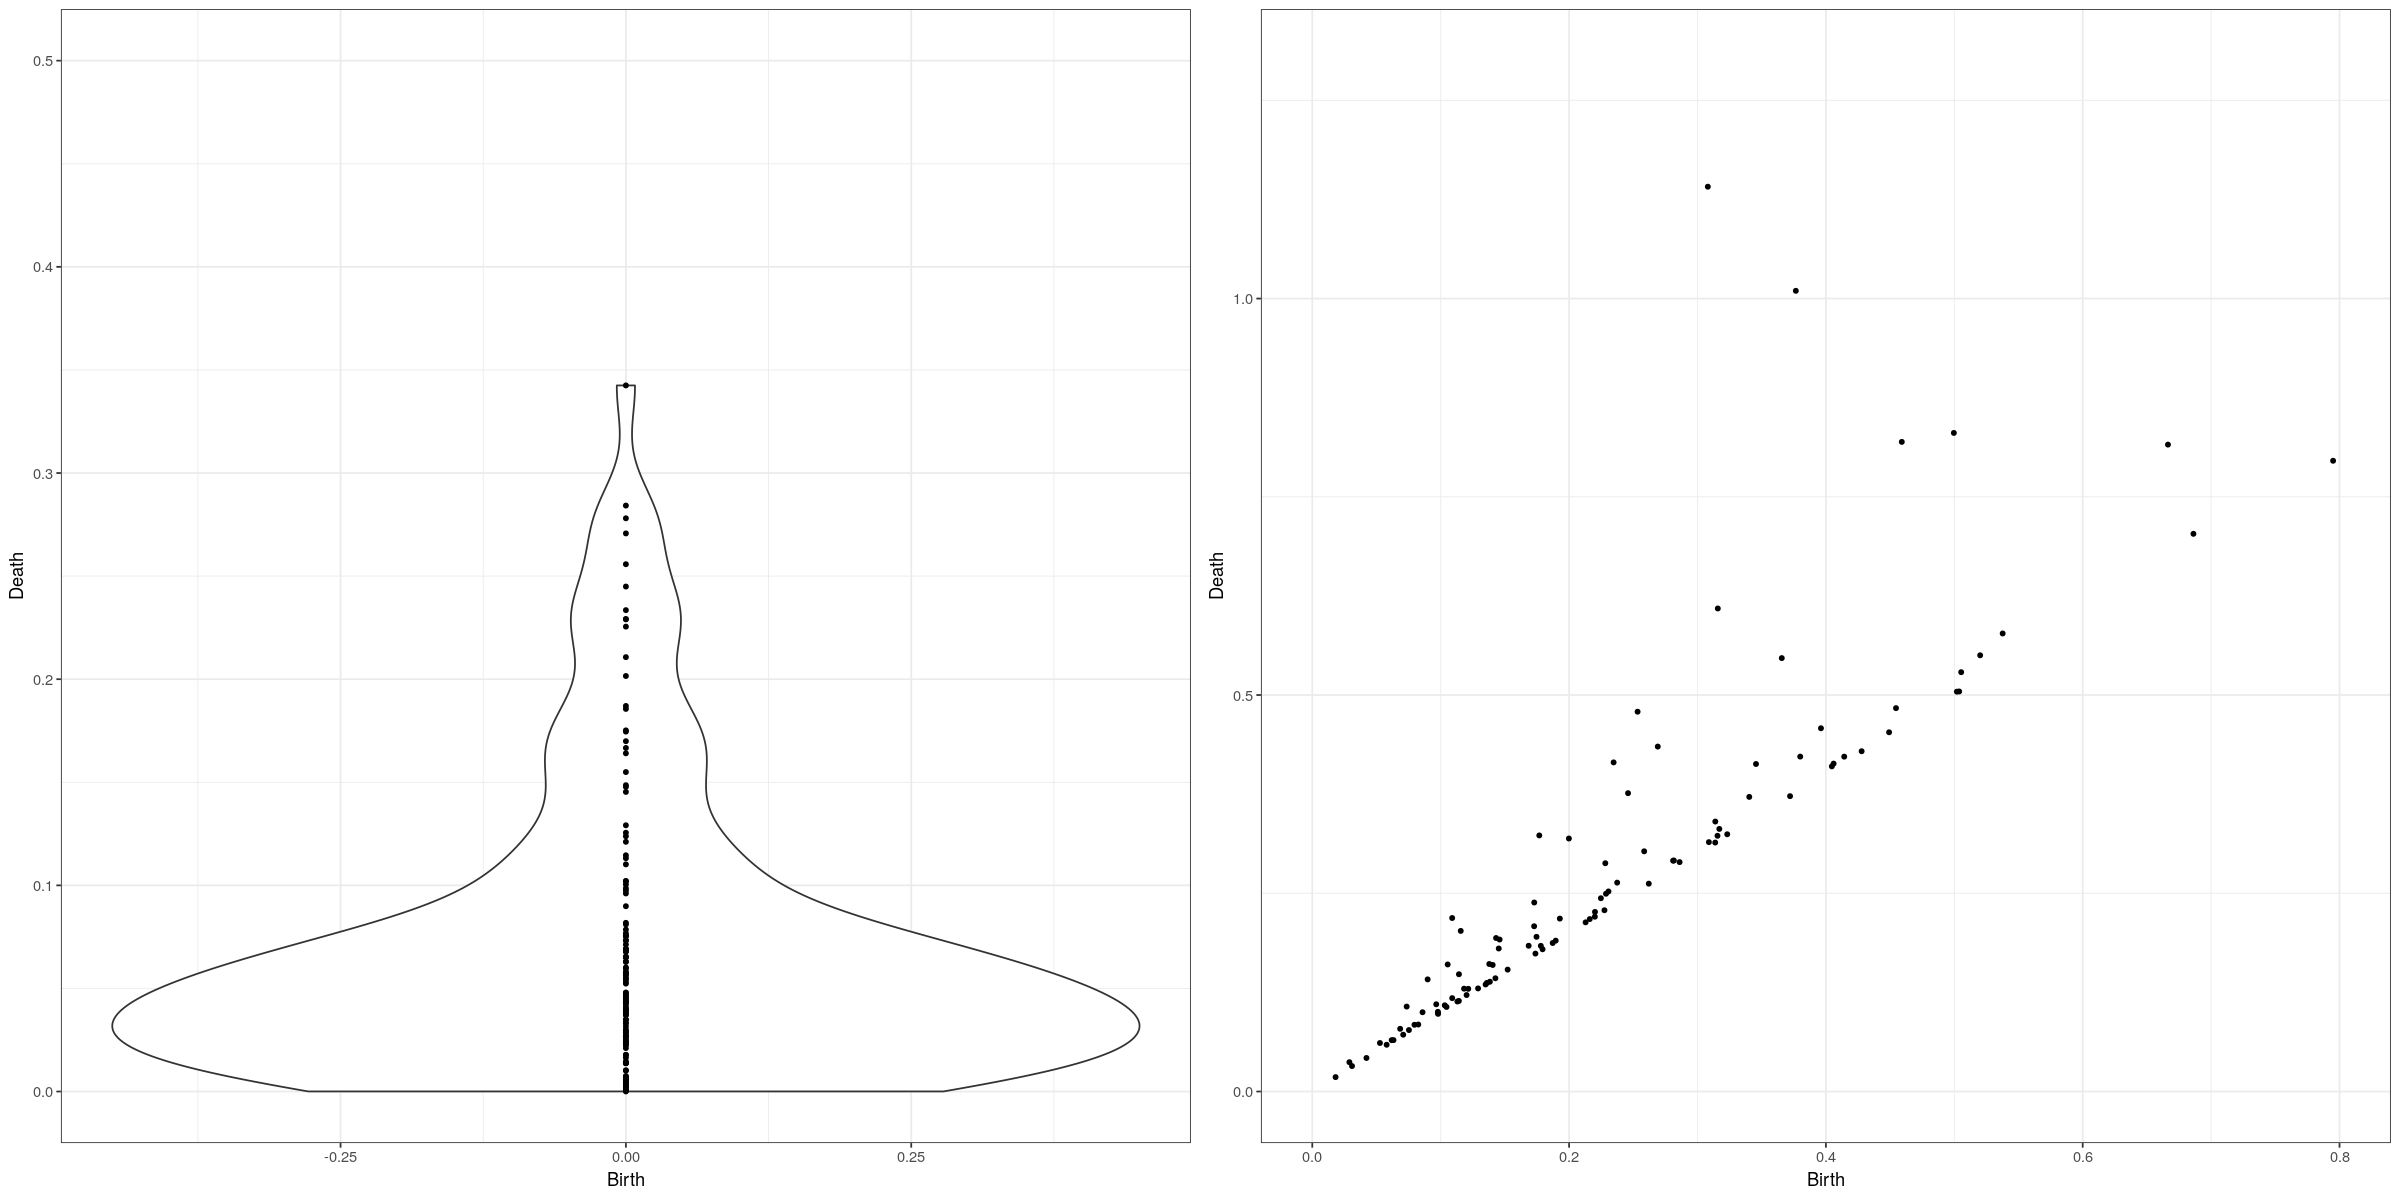

In [3]:
library(grid)
library(gridExtra)

#0-features
plots0 <- lapply( list(ppp),
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 0, 
                                                 2:3][-1,]), 
                            aes(x = Birth, y = Death)) +
                            geom_violin() +
                            geom_point(size = 1) +
                            scale_y_continuous(limits = c(0, 0.5)) +
                            theme_bw()                           
                    })

#1-features
plots1 <- lapply(list(ppp),
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 1, 2:3]), 
                            aes(x = Birth, y = Death)) +
                            geom_point(size = 1) +
                            scale_x_continuous(limits = c(0, .8)) + 
                            scale_y_continuous(limits = c(0, 1.3)) +
                            theme_bw()
                    })

grid.arrange(grobs = list(plots0[[1]], 
                           plots1[[1]]),
            ncol = 2, nrow = 1)

### Test statistics

The functional limit theorem shows that continuous functionals of the persistence diagram are asymptotically Gaussian. We illustrate this effect at hand of two specific statistics for 0- and 1-dimensional features, that were also considered in the setting of [$M$-bounded features](https://arxiv.org/abs/1906.07608).

For features in dimension 0, we look at the integrated number of cluster deaths until  a time $r_{\mathsf c}$, i.e.,
$$\int_0^{r_{\mathsf c}} \mathsf{PD}^0(\mathcal P_n)([0, d]) {\rm d}d.$$
Since it is a continuous functional of the persistence diagram, it is asymptotically normal, so that we deduce from the functional CLT that it becomes Gaussian in large windows. When dealing with data, the intensity needs to be estimated and [it was found](https://projecteuclid.org/euclid.ejs/1582534816) that the following intensity-adapted variant leads to superior test powers:
\begin{align}
        \label{t0Def}
        T_{\mathsf C} = \frac1{\sqrt{\hat\lambda}|W|}\int_0^{r_{\mathsf C} / \sqrt{\hat\lambda}} \mathsf{PD}^0(\mathcal P_n)([0, d]) {\rm d}d.
\end{align}

In [8]:
t_vals0 <- seq(0, .299, by = 1e-3)

tda0_raw <- function(coords){
    #' Death times of a point pattern
    #'
    #' @param coords coordinates of point pattern
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <-  data.frame(dimension = diag[,1], 
                           death = diag[,3])
    sort(diag_df[diag_df$dimension == 0, 'death'])  
}

tda0 <- function(X, 
                 r = 0, 
                 tx = t_vals0,
                 correction = NULL){
    #' Adapter of death times for spatstat scaled by number of points
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param t_vals time values for which the accumulated death count is computed
    #' @param correction edge correction
    dt <- tda0_raw(cbind(X$x, X$y))
    
    #intensity 
    intens <- X$n / area.owin(win)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = findInterval(tx, dt) / (sqrt(intens) * area.owin(win))), 
       valu = 'trans',
       labl = c('r', 'lab'),
       fname='Diag')
}

For 1-dimensional features, we rely on the [accumulated persistence function](https://www.tandfonline.com/doi/abs/10.1080/10618600.2019.1573686?journalCode=ucgs20). That is, we aggregate the life times of all loops with birth times in a time interval $[0, r_{\mathsf L}]$ with $r_{\mathsf L} \le r_{\mathsf f}$:
$$\int_{[0, r_{\mathsf L}] \times [0, r_{\mathsf f}]} (d - b) \mathsf{PD}^1(\mathcal P_n)({\rm d}b, {\rm d}d).$$

As before, adapting to the intensity results in the loop-based statistic 
\begin{align}
        \label{t1Def}
        T_{\mathsf L} =  \frac1{\sqrt{\lambda}|W|}\int_{[0, r_{\mathsf L} / \sqrt \lambda] \times [0, r_{\mathsf f} / \sqrt \lambda]} (d - b) \mathsf{PD}^1(\mathcal P_n)({\rm d}b, {\rm d}d)
\end{align}

In [9]:
t_vals1 <- seq(0, .499, by=5e-3)
ty1 <- seq(0, .299, by=1e-2)

tda1_raw <- function(coords,
                     max_bt = 10){
    #' accumulated persistence function of a point pattern
    #'
    #' @param coords coordinates of point pattern
    #' @param max_bt add maximum birth time to avoid out of bound error
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <- data.frame(dimension = diag[,1], 
                           birth = diag[,2], 
                           life = (diag[,3] - diag[,2]))
    
    #only 1-dimensional features
    diag_df <- diag_df[diag_df$dimension == 1, 2:3]
    diag_df <- diag_df[order(diag_df$birth),]
    rownames(diag_df) <- c()
    rbind(diag_df, c(max_bt, max_bt))
}

tda1 <- function(X, 
                 r = 0, 
                 tx = t_vals1,
                 correction = NULL){
    #' Adapter of the accumulated persistence function for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx times at which the APF is computed
    
    tda1_vals <- tda1_raw(cbind(X$x, X$y))
    tda1_vals <- cbind(tda1_vals[,1], cumsum(tda1_vals$life))  
    birth_locs = findInterval(tx, tda1_vals[,1])
    
    #intensity 
    intens <- X$n / area.owin(win)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = tda1_vals[1 + birth_locs, 2] / (sqrt(intens) * area.owin(win))), 
      valu = 'trans',
      labl = c('r', 'lab'),
      fname='Diag')
}

### Asymptotic Gaussianity

By the functional CLT, the cluster- and loop-based statistics $T_{\mathsf C}$ and $T_{\mathsf L}$ are asymptotically Gaussian. We now illustrate that this distributional convergence becomes already clearly apparant on bounded sampling windows. To that end, we first compute the statistics on the iid samples of the Poisson process.

In [10]:
library(parallel)

#compute summary statistics
funs_sum <- list(function(X) mean((tda0(X)$trans[1:100])),
                 function(X) mean(tda1(X)$trans))

null_stats <- lapply(funs_sum, 
                    function(f) as.numeric(mclapply(ppps, 
                                         function(X) f(X),
                                                    mc.cores = 36))
                    )
                 
#normalize 
null_means <- lapply(null_stats, mean)
null_sds <- lapply(null_stats, sd)
null_norms <- lapply(1:2,
                    function(i) data.frame(x = (null_stats[[i]] - null_means[[i]]) / null_sds[[i]])
                    )

The histograms and Q-Q-plots for the normalized statistics illustrate impressively that the Gaussian distribution is already clearly visible on a bounded sampling window.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



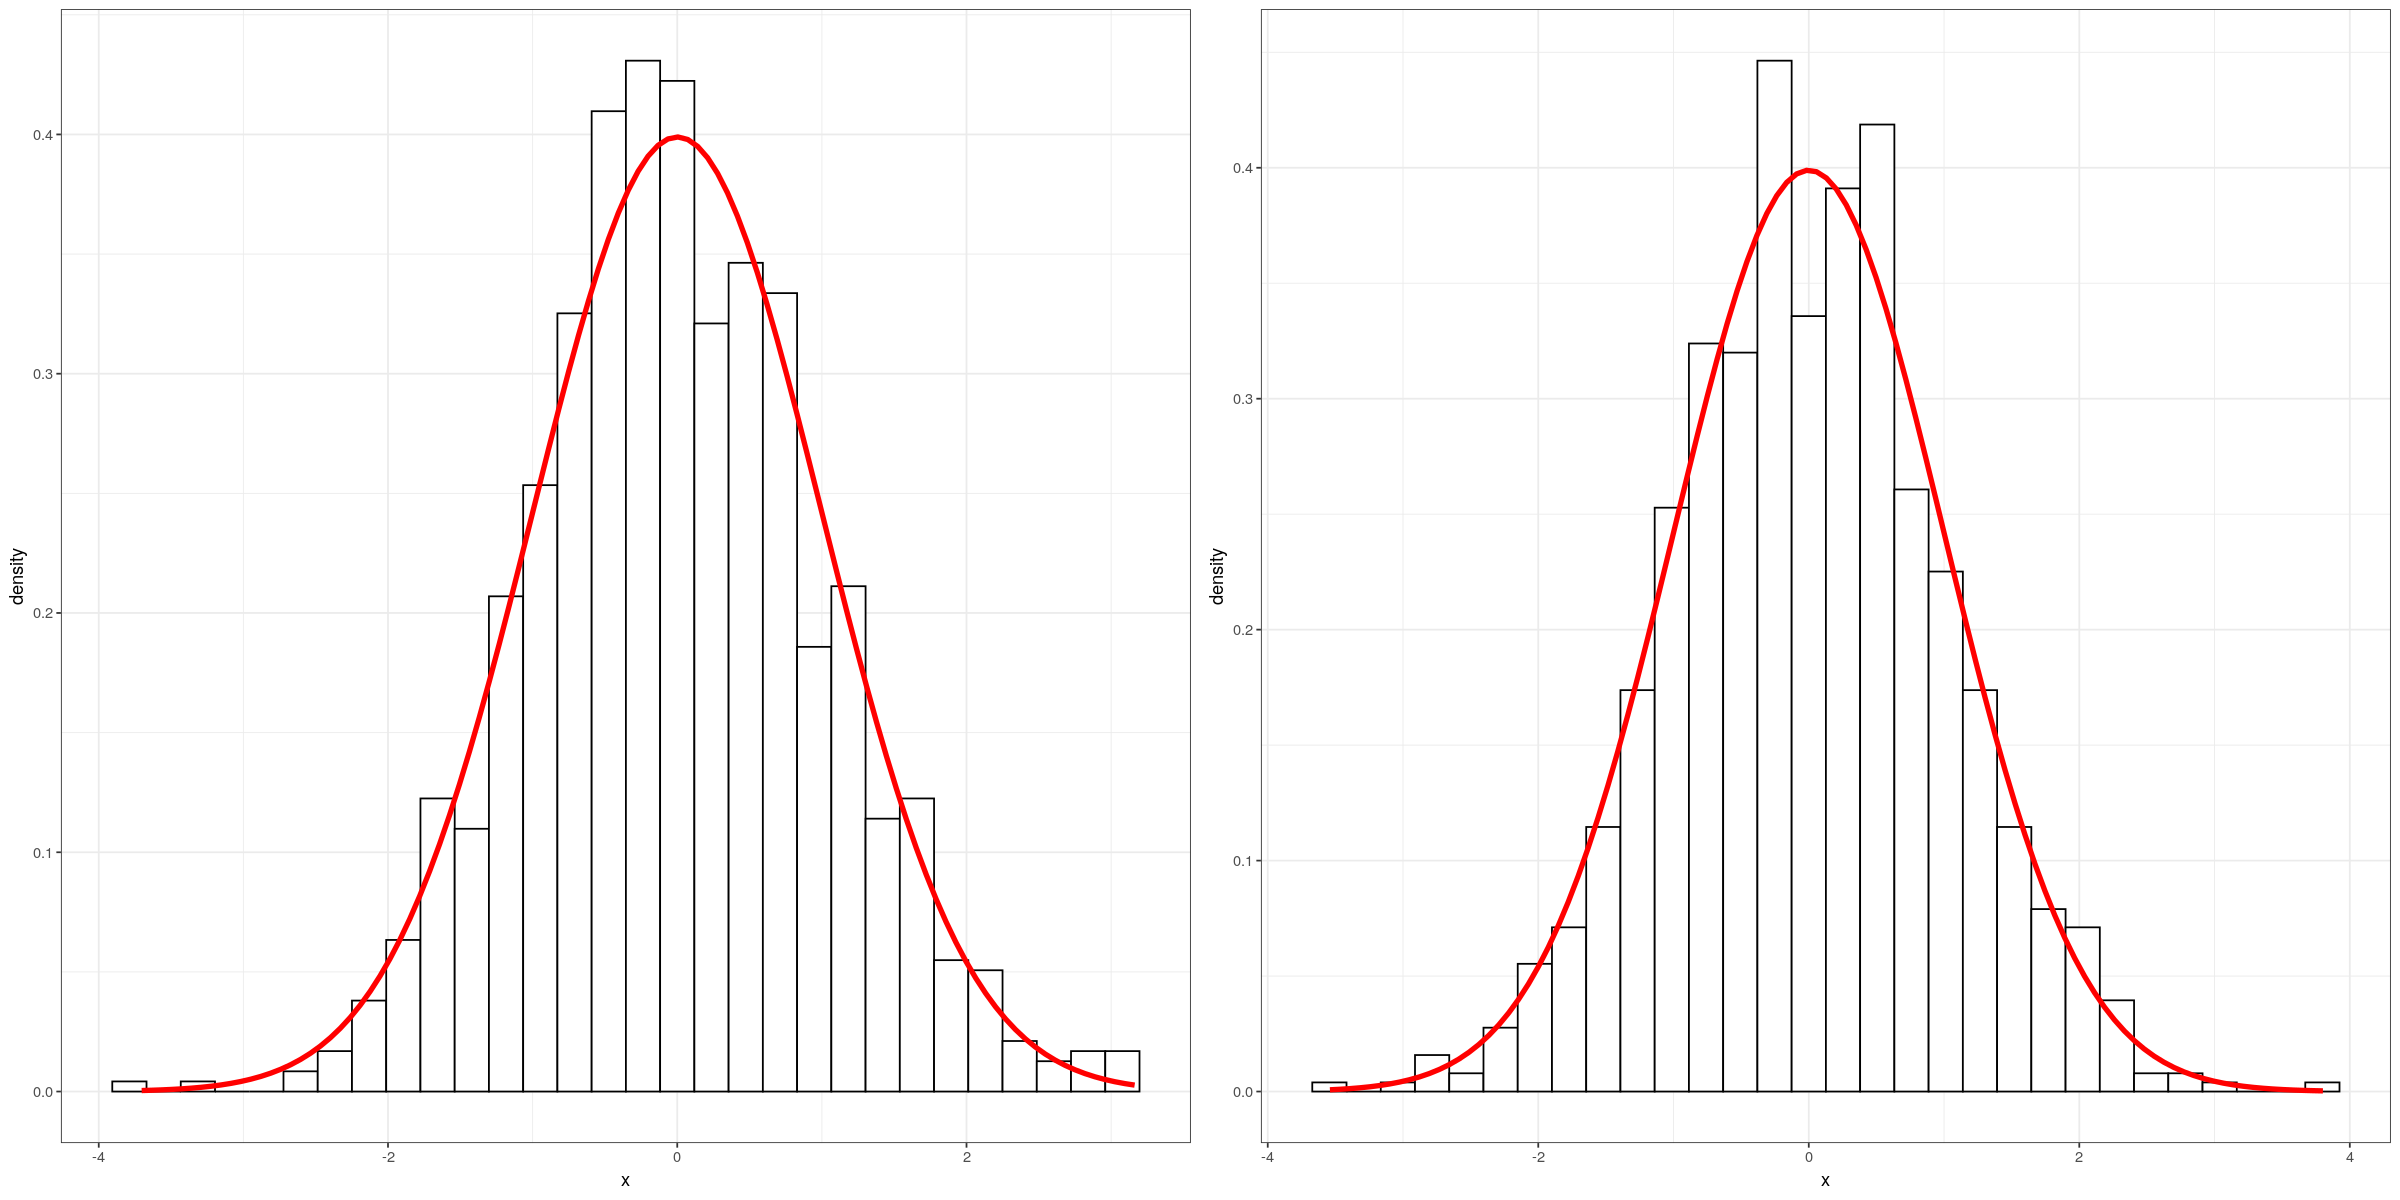

In [11]:
hists <- lapply(null_norms, function(norm) ggplot(norm, aes(x = x)) +
        geom_histogram(aes(y = ..density..),
                       color = 'black',
                       fill="white") +
        stat_function(fun = dnorm, 
                      colour = "red",
                      size = 1.5) + 
        theme_bw()
                )

grid.arrange(grobs = list(hists[[1]], 
                           hists[[2]]),
            ncol = 2, nrow = 1)

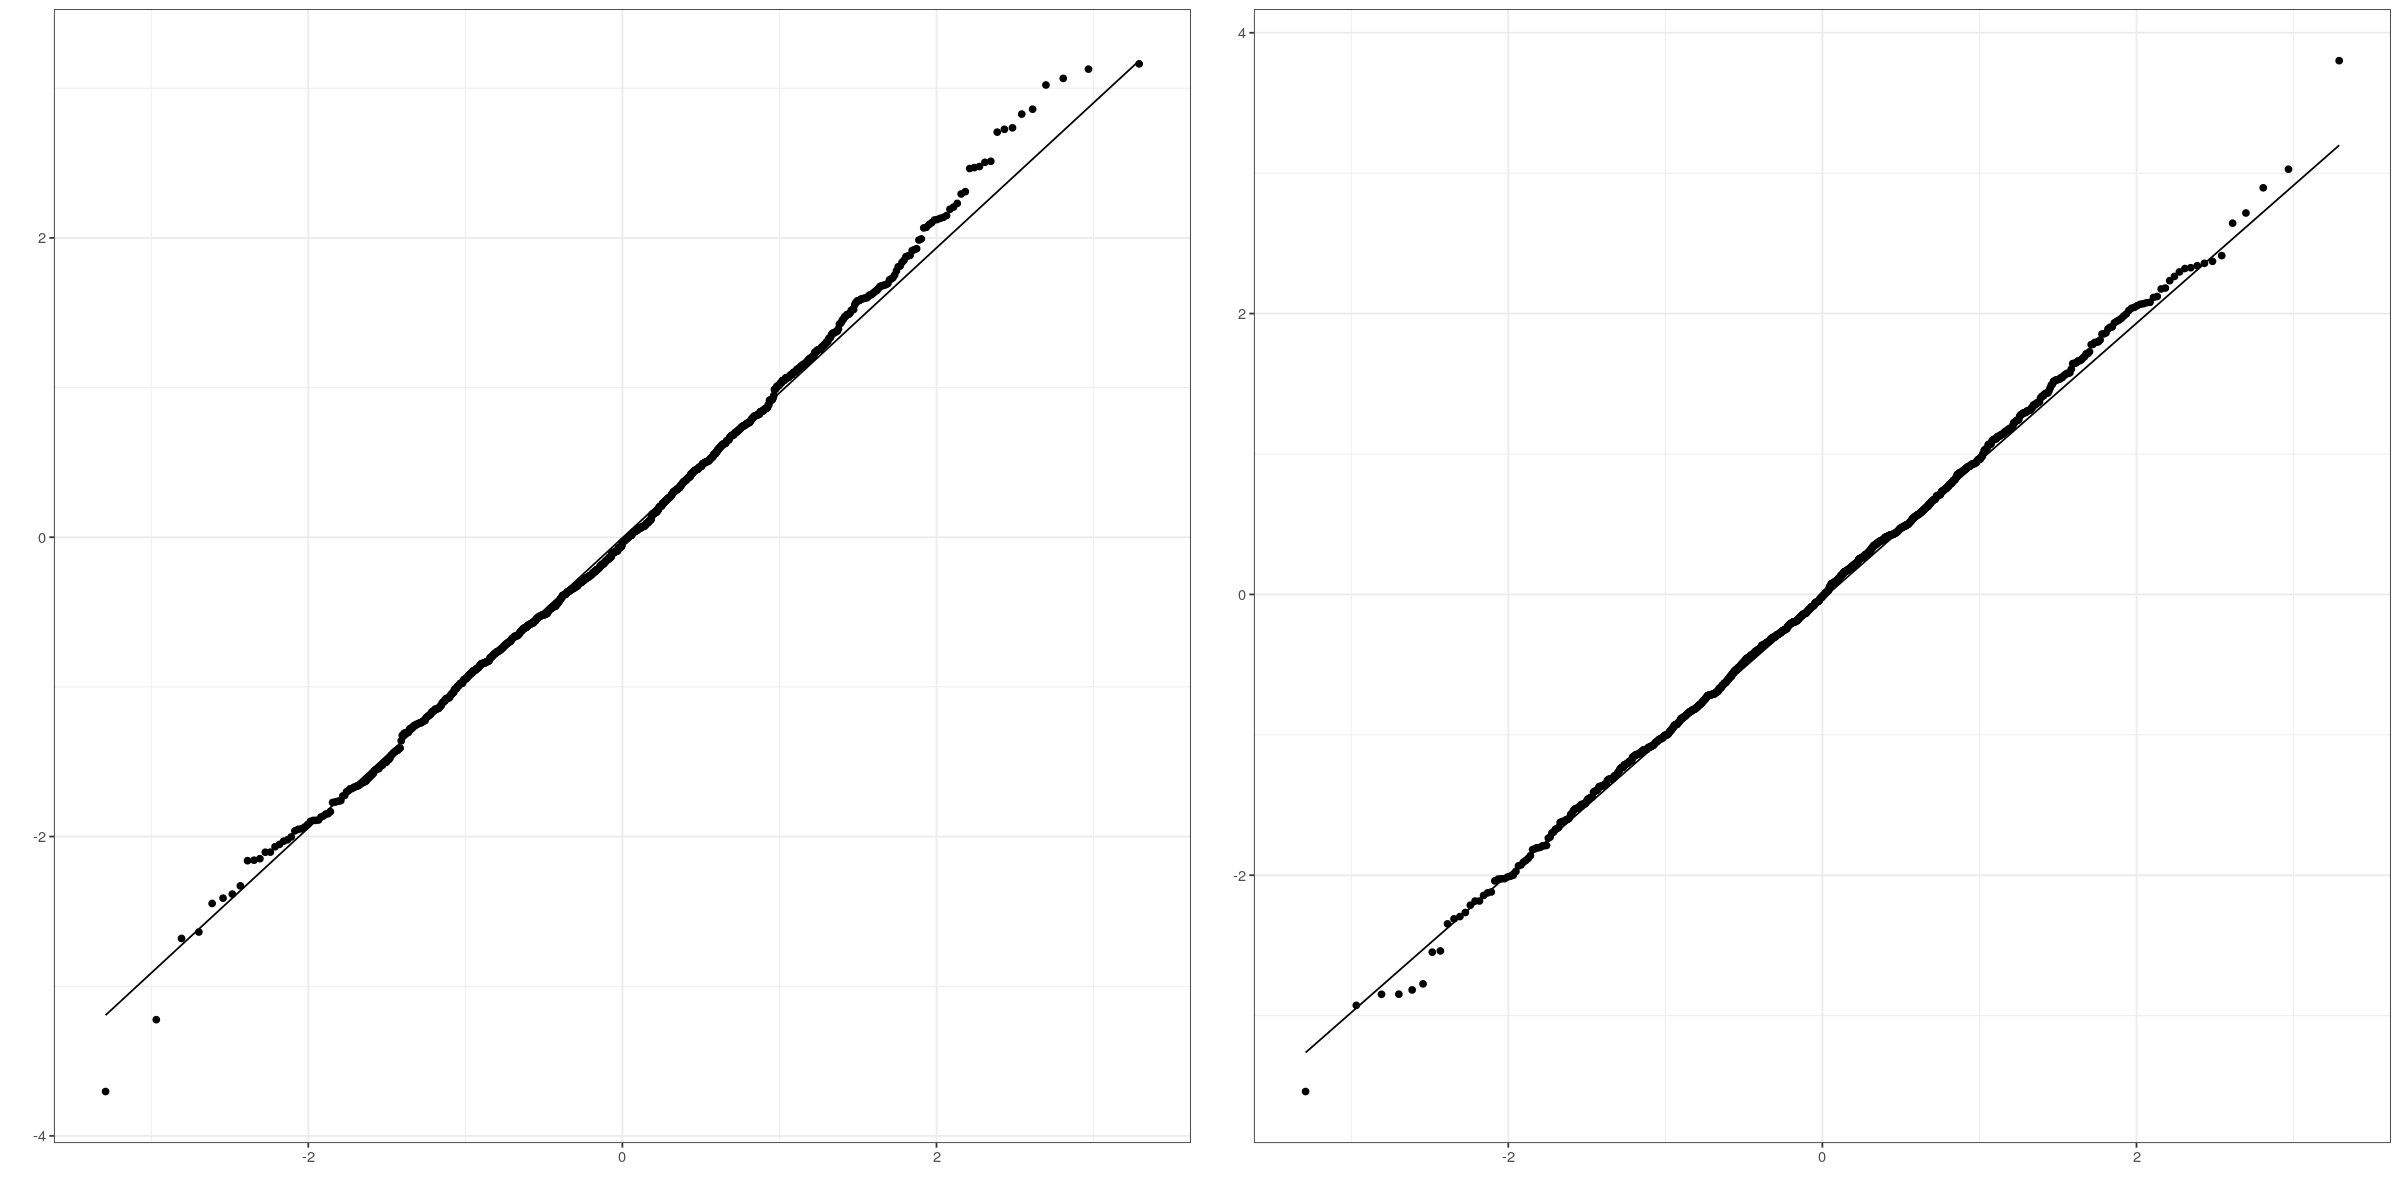

In [12]:
qplots <- lapply(null_norms,
                 function(norm) qplot(sample = x, data = norm) + 
                    stat_qq_line() +
                    theme_bw()
                 )
grid.arrange(grobs = list(qplots[[1]], 
                           qplots[[2]]),
            ncol = 2, nrow = 1)

### Goodness of fit tests

After illustrating that the test statistics $T_{\mathsf C}$ and $T_{\mathsf L}$ are asymptotically Gaussian, we now sketch how to derive goodness of fit tests. For this purpose, we introduce point patterns that are more clustered or more repulsive than the Poisson point process. To be more precise, the Matérn cluster process $\mathsf{MatC}(2, 0.5, 1)$ features a Poisson parent process with intensity 2 and generates a $\mathsf{Poi}(1)$ number of offspring uniformly in a disk of radius $0.1$ around each parent. The Strauss process $\mathsf{Str}(4.0, 0.6, 0.5)$ has interaction parameter $0.6$ and interaction radius $0.5$, respectively.

In [62]:
seed <- 48
set.seed(seed)
nsim <- 1e3

time <- Sys.time()

ppps_val <- rpoispp(2, 
                    win = win, 
                    nsim = nsim)

mcps <- rMatClust(2, .5, 1, 
                  win = win,
                  nsim = nsim) 

strs <- rStrauss(4.0, .6, .5,  
                 W = win,
                 nsim = nsim)
Sys.time() - time

Time difference of 18.27153 secs

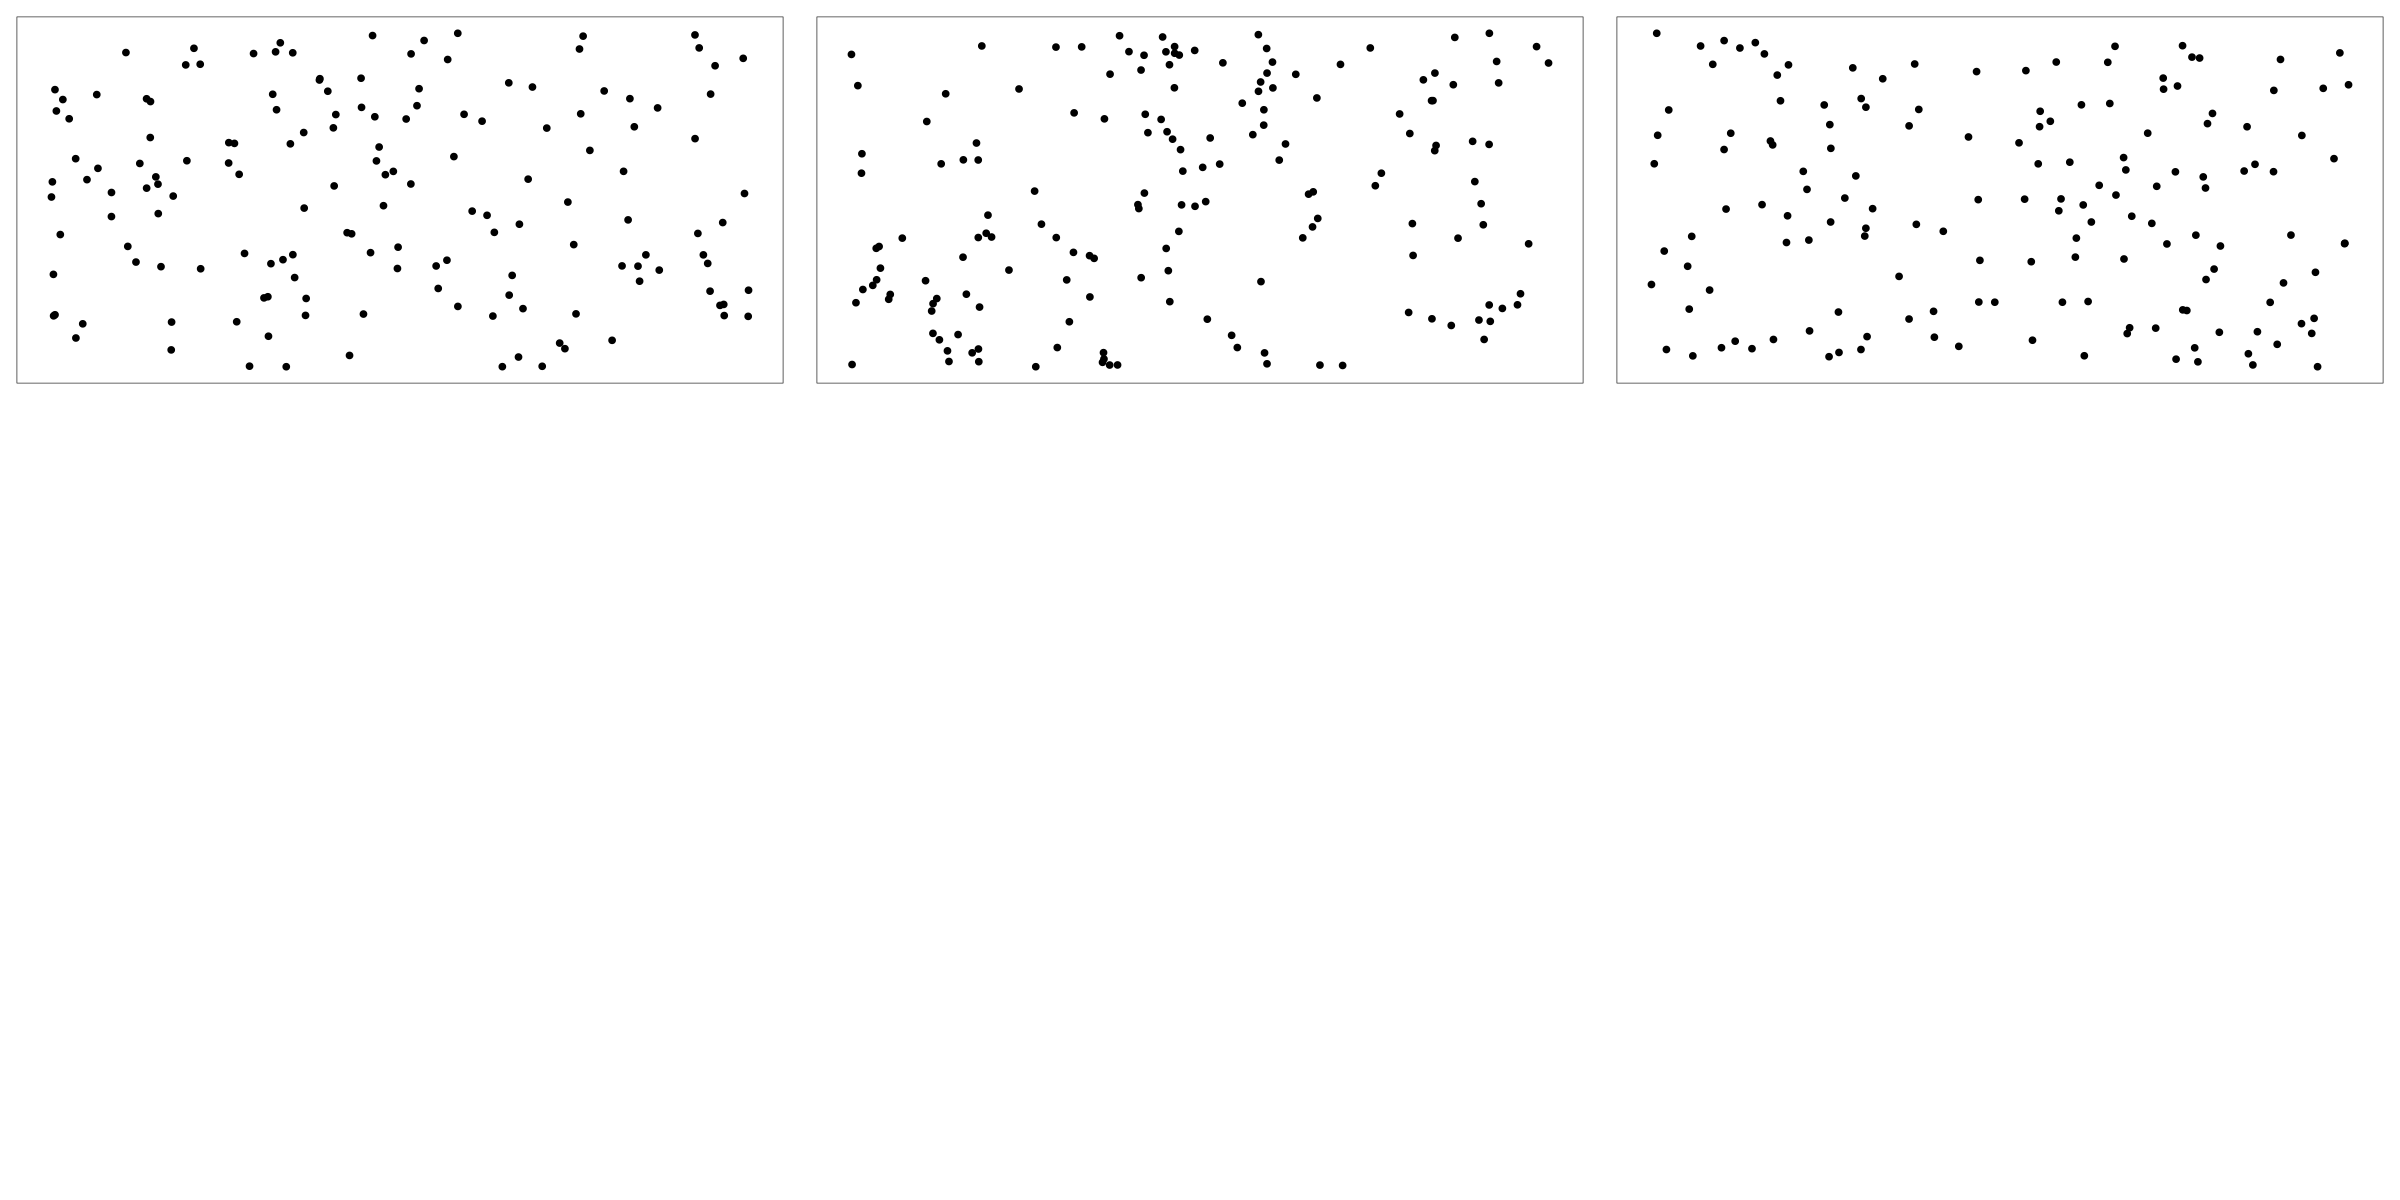

In [42]:
library(gridExtra)

real <- 5

samples <-list(ppps_val[[real]], 
               mcps[[real]],  
               strs[[real]])

plots <- lapply(samples, 
                function(pp) qplot(x = pp$x, 
                                   y = pp$y, 
                                   size = I(1.5)) + 
                    theme_void() +
                    theme(plot.margin = margin(10, 10, 10, 10)) +
                    theme(panel.border = element_rect(fill = NA)) 
                )
grid.arrange(plots[[1]], 
             plots[[2]], 
             plots[[3]], 
             clip = F,
             nrow = 3, ncol = 3)

We see that when drawing samples from the Poisson null model, the actual type 1 error is close to the nominal asymptotic 5 \% level. When moving to the type 2 errors, we see that the TDA-based tests often succeed in detecting deviations from the null hypothesis. More precisely, for the attractive point pattern, the null hypothesis is rejected in 44.4\% and 36.6\% of the samples by the tests based on $T_{\mathsf C}$ and $T_{\mathsf L}$. For the repulsive point pattern, the corresponding rates are 50.5\% and 47.4\%, respectively.

In [15]:
p_val <- function(X,
                  stat,
                  null_mean,
                  null_sd){
    #' p-value for deviation test
    #'
    #' @param pp point pattern to be tested
    #' @param stat test statistics
    #' @param null_mean mean under the null model
    #' @param null_sd standard deviation under the null model
    z_val <- abs(stat(X) - null_mean) / null_sd
    2 * (1 - pnorm(z_val))
}

In [21]:
alpha <- .05
pps_list <- list(ppps_val, mcps, strs)

do.call(rbind.data.frame,
        lapply(seq(length(funs_sum)),
               function(i) sapply(pps_list,
                                  function(pp_list) sum(
                                      mclapply(pp_list, 
                                               function(pp) p_val(pp, 
                                                                  funs_sum[[i]],
                                                                  null_means[[i]], 
                                                                  null_sds[[i]]),
                                               mc.cores = 36
                                              ) < alpha) 
                                  )
               )
       )

c.53L..42L.,c.444L..505L.,c.366L..474L.
<int>,<int>,<int>
53,444,366
42,505,474


## Directed spanning tree

The random geometric graph from the previous section corresponds to the standard situation for building the Čech complex for a union of growing balls. Next, we illustrate the asymptotic normality for a prototypical example of a geometric tree network, namely the [directed spanning tree](https://projecteuclid.org/euclid.aoap/1171377186).

In this directed network model, the nodes are given by a spatial point process $X = \{X_i\}_{i \ge 1}$ and every node $X_i$ has precisely one outgoing arrow. More precisely, among all nodes to the right of $X_i$ we select the one at the smallest Euclidean distance.

In [3]:
dsf <- function(X){
    #' Directed spanning forest
    #'
    #' @param X point pattern

    #order increasing in x-direction
    x_ord <- X$x[order(X$x)]
    y_ord <- X$y[order(X$x)]
    points_ord <-cbind(x_ord, y_ord)
    len <- length(x_ord)

    #distance matrix
    dists <- pairdist(points_ord)

    #outgoing edge
    neighbs <- sapply(1:(X$n - 1),
                      function(i) i + which.min(dists[i, (i+1):X$n])
                      )
    
    #ingoing edges
    in_neighbs <- lapply(1:X$n, function(x) list())
    for(i in 1:(X$n - 1)) 
    in_neighbs[[neighbs[i]]] <- append(in_neighbs[[neighbs[i]]], 
                                                i)
    
    neighbs <- c(neighbs, X$n)
    list(points_ord, 
         neighbs,
         in_neighbs)         
}

Now, we illustrate the DSF on a Poisson point process.

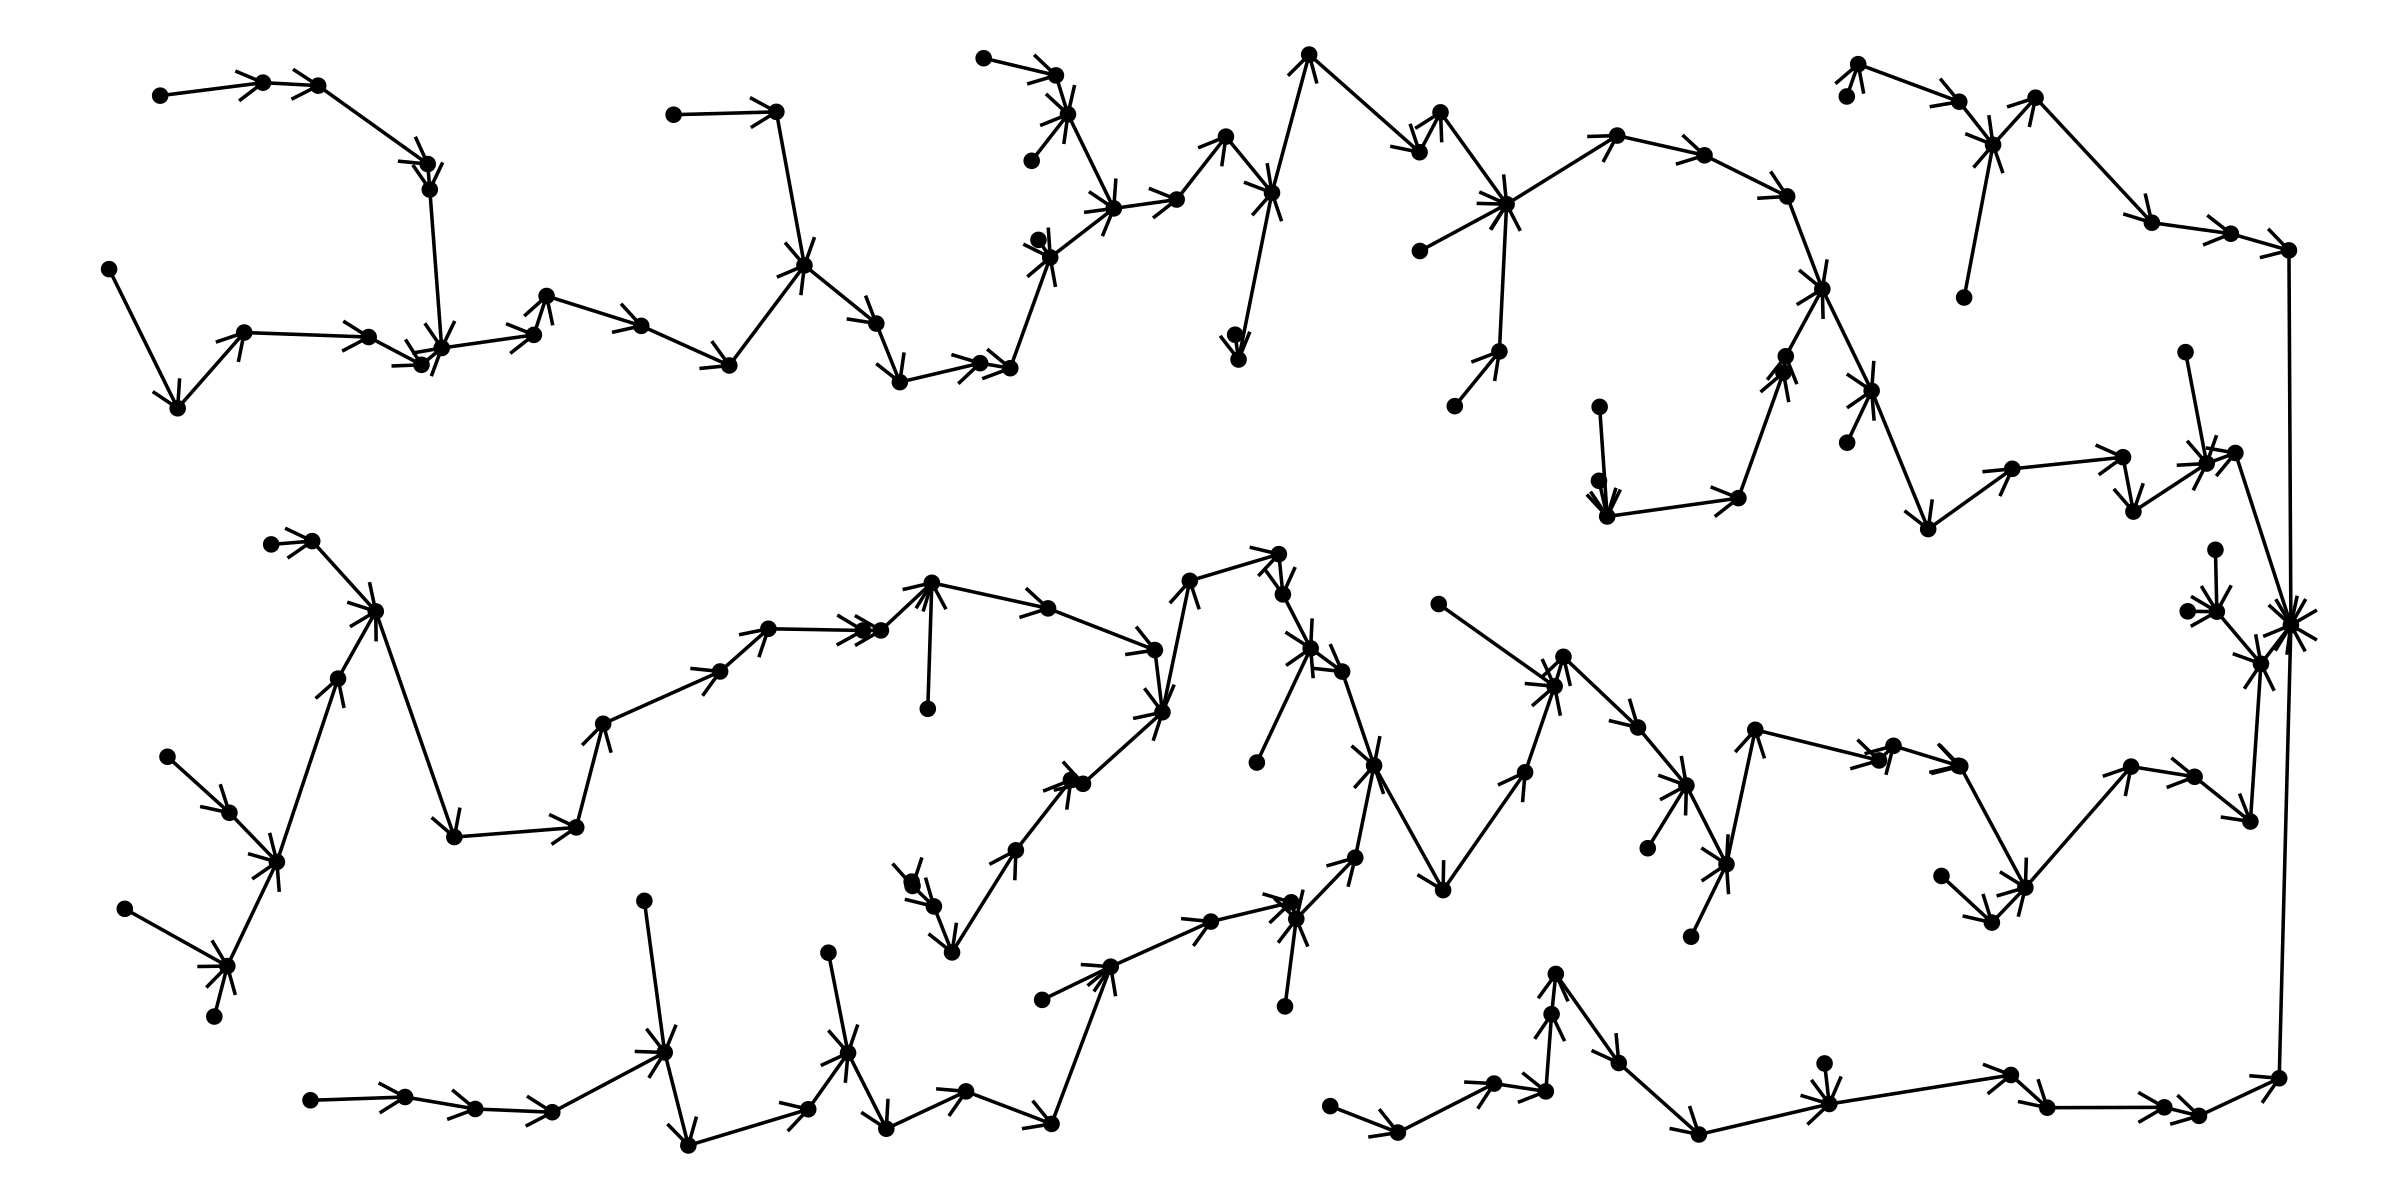

In [4]:
real <- 3
dsf_samp <- dsf(ppps[[real]])

pp_ord <- dsf_samp[[1]]
neighb_list <- dsf_samp[[2]]

df = data.frame(x = pp_ord[,1], 
                y = pp_ord[,2],
                xend = pp_ord[,1][neighb_list],
                yend = pp_ord[,2][neighb_list]
                )

ggplot() + 
geom_segment(data=df, 
             mapping=aes(x=x, y=y, xend=xend, yend=yend), 
             arrow=arrow(), 
             size=1) + 
    geom_point(data=df, 
               mapping=aes(x=x, y=y), 
               size=4) +
    theme_void()

Export the drawing to tikz.

In [132]:
pic_tikz <- file("./long_time.tex")
pt_size <- 1
digits <- 2
width <-  15
height <- 5
x_offset <- 15

squeeze_height <- .3
y_offset <- squeeze_height * nrow(df) / 2 - height / 2

code <- c()

#order by birth
df <- df[order(df[,1]),]

for(i in seq(1, nrow(pp_ord), by = 5)){
    

code <- c(code, '\\begin{tikzpicture}')

    
    #bounding box
    pt <- paste0('\\draw[white] (', x_offset + width, 
                 ',', squeeze_height * (nrow(df) + 1),
                 ') -- (', x_offset + width, 
                 ',', -1,
                 ');')
    code <- c(code, pt)
    
    x_cur <- pp_ord[i, 1]
    
#dsf
for(j in 1:nrow(pp_ord)){
    ##pts
    pt <- paste0('\\fill (', format(round(pp_ord[j,1], digits), nsmall = digits), 
                 ',', format(round(y_offset + pp_ord[j,2], digits), nsmall = digits),
                 ') circle (',pt_size,'pt);')
    code <- c(code, pt)
    
    ##arrows
    arr <- paste0('\\draw (', format(round(pp_ord[j,1], digits), nsmall = digits), 
                 ',', format(round(y_offset + pp_ord[j,2], digits), nsmall = digits),
                 ') -- (', format(round(pp_ord[neighb_list[j],1], digits), nsmall = digits), 
                 ',', format(round(y_offset + pp_ord[neighb_list[j],2], digits), nsmall = digits),
                 ');')
    
    
    code <- c(code, arr)
    }
    
##scanner
    cur_pt <- paste0('\\fill[red] (',format(round( x_cur, digits), nsmall = digits), 
                 ',', format(round(y_offset + pp_ord[i,2], digits), nsmall = digits),
                 ') circle (', 3 * pt_size,'pt);') 
    code <- c(code, cur_pt)
    
    #left dash
    dash <- paste0('\\draw[dashed] (', format(round( x_cur, digits), nsmall = digits), 
                 ', ',y_offset,') -- (',format(round( x_cur, digits), nsmall = digits), 
                 ',', y_offset + height, 
                 ');' )   
    code <- c(code, dash)
    
    #barcode
    
    ##births
    df_birth <- df[df[,1]  <= x_cur,]
    if(nrow(df_birth)>0){
    for(j in 1:nrow(df_birth)){
        bar <- paste0('\\draw[very thick] (', format(round(x_offset + df_birth[j,1], digits), nsmall = digits), 
                 ',', squeeze_height *(nrow(df) - j),
                 ') -- (', format(round(x_offset + min(x_cur, df_birth[j,2]), digits), nsmall = digits), 
                 ',', squeeze_height *(nrow(df) - j),
                 ');')
        code <- c(code, bar)
    }
        }
    
    #right dash
    dash_bar <- paste0('\\draw[dashed] (', format(round(x_offset + x_cur, digits), nsmall = digits), 
                 ', ',squeeze_height * nrow(df),') -- (', format(round(x_offset + x_cur, digits), nsmall = digits), 
                 ',', squeeze_height * (nrow(df) - nrow(df_birth)), 
                 ');' )   
    code <- c(code, dash_bar)
    
    code <- c(code, '\\end{tikzpicture}')

    }


#barcode


writeLines(code, pic_tikz)
close(pic_tikz)

Now, we compute the persistence diagram associated with the sub-level filtration of merging branches when scanning in the $x$-direction.

In [5]:
pd_tree <- function(nodes,
                    nbs_in){
    #' Persistence diagram of tree. Input data should be ordered.
    #'
    #' @nodes node coordinates
    #' @param nbs_in in-neighbors

    comps <- matrix(, 
                    nrow = 0, 
                    ncol = 2)
    
    #birth and death times
    b_d <-  matrix(, 
                    nrow = 0, 
                    ncol = 2)

    for(i in 1:(length(nbs_in) )){
        #birth
        if(length(nbs_in[[i]])==0)
            comps <- rbind(comps, c(i,i))
        #death
        else{
            #which clusters are merged?
            merge_idxs <- match(c(nbs_in[[i]]), comps[,2])
            #oldest cluster
            idx_old <- which.min(comps[merge_idxs,1])

            #update surving component
            idx_surv <- merge_idxs[idx_old]
            comps[idx_surv,2] <-i
            
            #kill other components            
            if(length(merge_idxs) > 1){
                bd_inc <- matrix(, 
                                 nrow = length(merge_idxs[-idx_old]), 
                                 ncol = 2)
                bd_inc[,1] <- comps[merge_idxs[-idx_old],1]
                bd_inc[,2] <- i
                b_d <- rbind(b_d, bd_inc)
                
                comps <- comps[-(merge_idxs[-idx_old]),,drop=FALSE]   
                }
            }
        }
    #kill initial component
    b_d <- rbind(b_d, c(1, length(nodes)/2))
    cbind(nodes[b_d[,1],1],
          nodes[b_d[,2],1])
    }

Now, we plot the persistence diagram for the Poisson null model

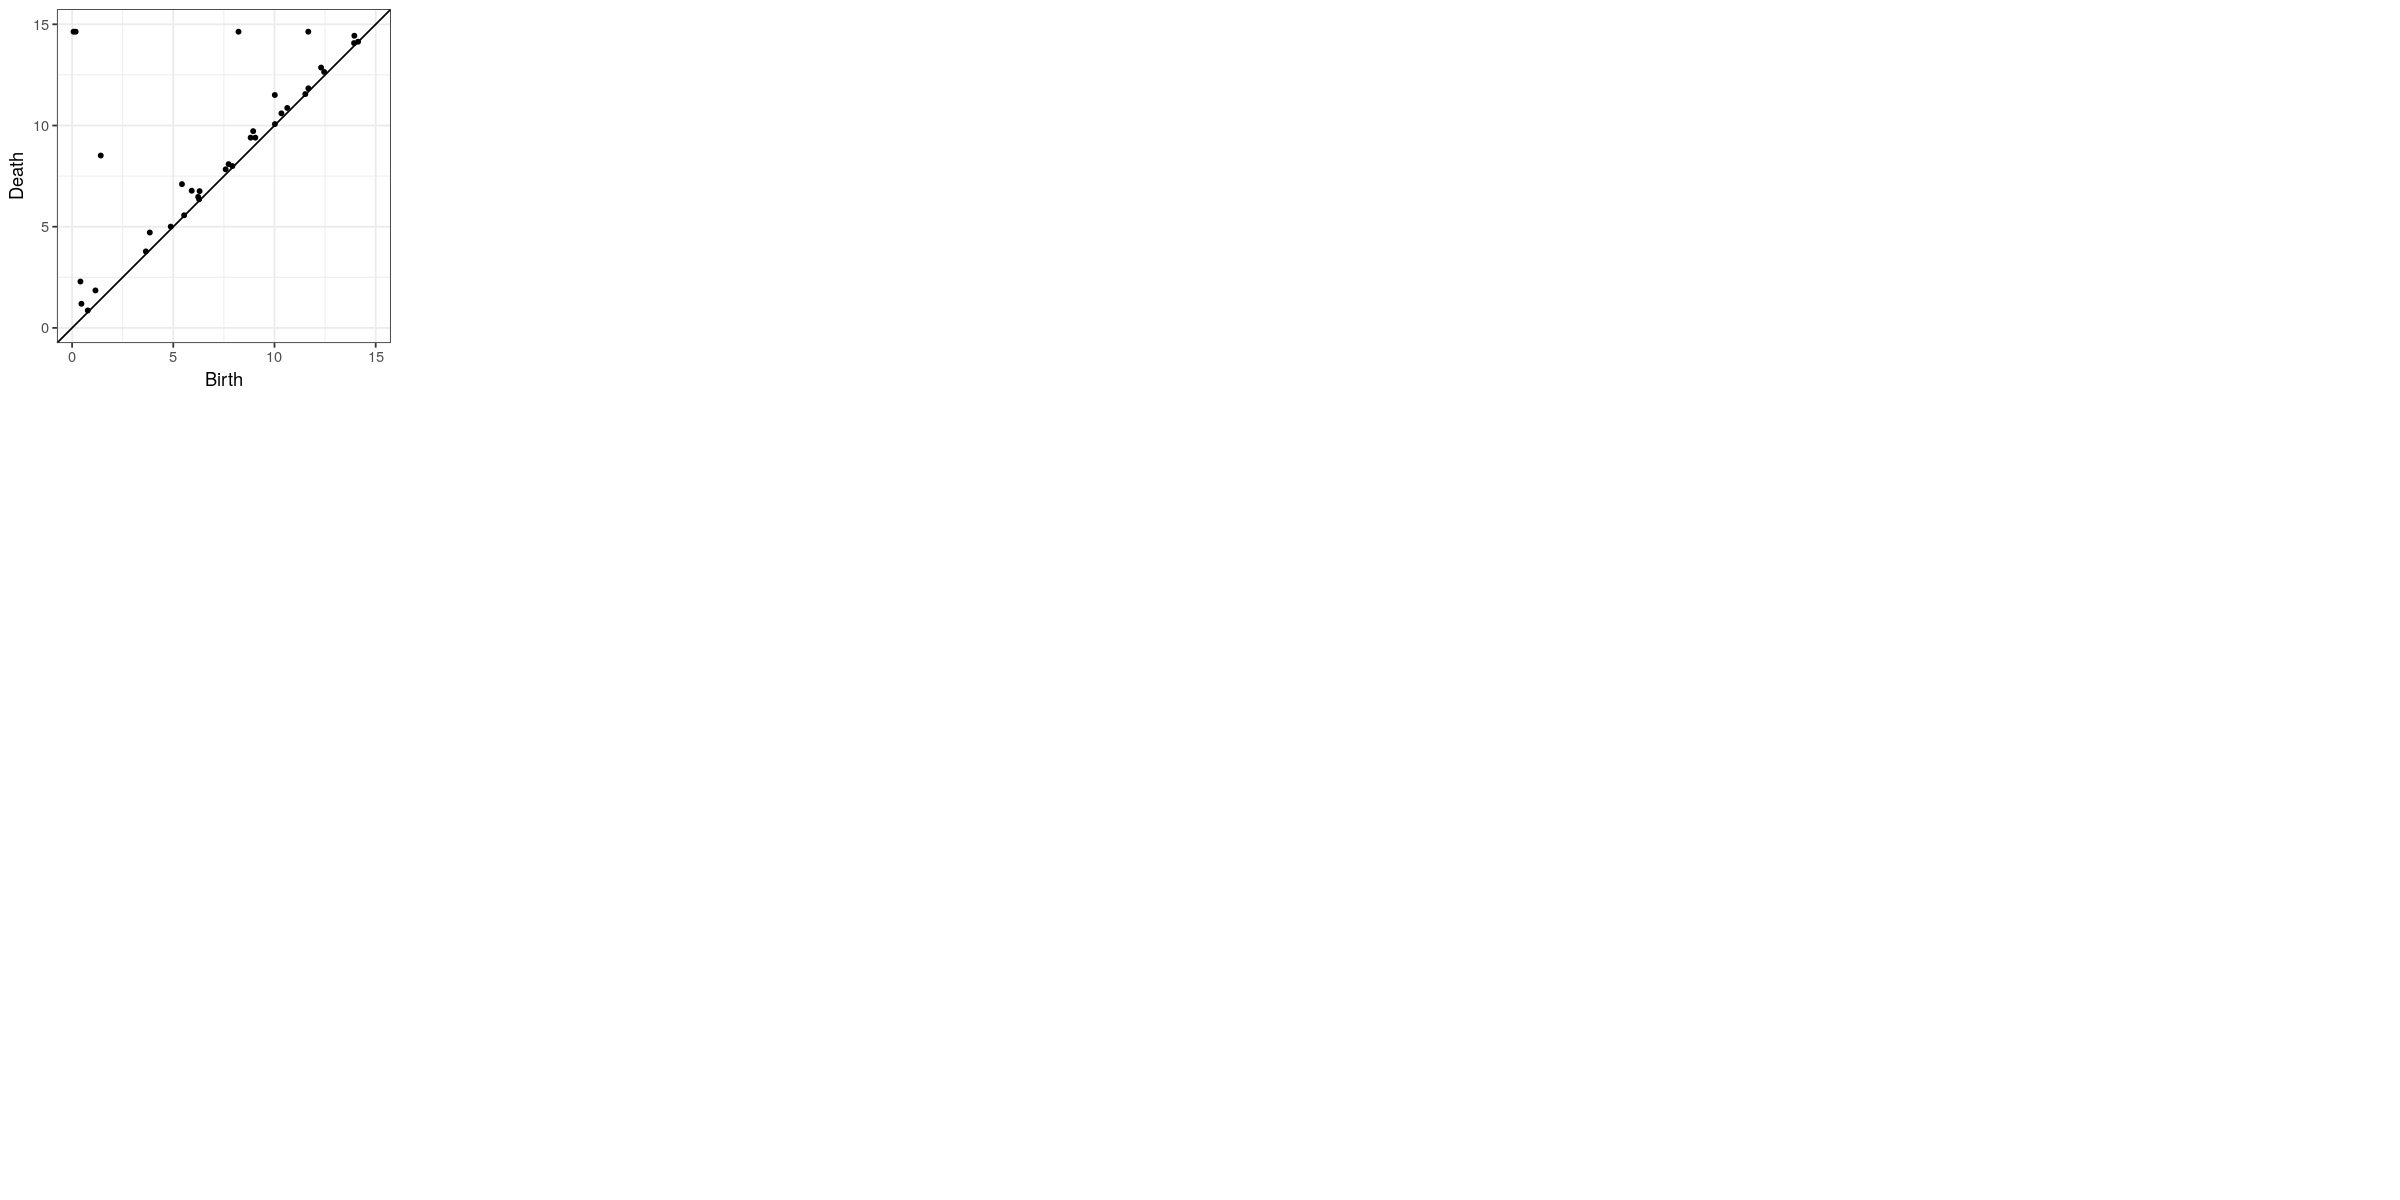

In [6]:
library(gridExtra)

points <- dsf(ppps[[3]])[[1]]
neighbs <- dsf(ppps[[3]])[[3]]

df <- data.frame(pd_tree(points,
                         neighbs))
colnames(df) <- c('Birth', 'Death')
dsf_plot <- ggplot(df, aes(x = Birth, y = Death)) +
            geom_abline(intercept = 0, slope = 1) +
            geom_point(size = 1) +
            scale_x_continuous(limits = c(0, 15)) + 
            scale_y_continuous(limits = c(0, 15)) +
            theme_bw()
grid.arrange(dsf_plot , 
             clip = F,
             nrow = 3, ncol = 6)

To compute the the aggregated persistence function, we adapt the method from the Čech complex.

In [7]:
t_vals0_net <- seq(0, 15.9, by=1e-1)
ty0_net <- seq(0, 9.99, by=1e-1)

tda0_raw_net <- function(tree,
                         max_lt = 5,
                         max_bt = 30){
    #' accumulated persistence function of a tree
    #'
    #' @param tree tree under consideration
    #' @param max_lt maximum lifetime to be considered
    #' @param max_bt add maximum birth time to avoid out of bound error
    
    diag <- pd_tree(tree[[1]], tree[[3]])
    diag_df <- data.frame(birth = diag[,1], 
                           life = (diag[,2] - diag[,1]))
    
    #only 1-dimensional features
    diag_df <- diag_df[diag_df$life < max_lt,]
    diag_df <- diag_df[order(diag_df$birth),]
    rownames(diag_df) <- c()
    rbind(diag_df, c(max_bt, max_bt))
}

tda0_net <- function(X, 
                 r = 0, 
                 tx = t_vals0_net){
    #' Accumulated persistence function for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx times at which the APF is computed
    
    tree <- dsf(X)
    tda0_vals <- tda0_raw_net(tree)
    tda0_vals <- cbind(tda0_vals[,1], cumsum(tda0_vals$life))  
    birth_locs = findInterval(tx, tda0_vals[,1])
    
    #intensity 
    intens <- X$n / area.owin(win)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = tda0_vals[1 + birth_locs, 2]),
      valu = 'trans',
      labl = c('r', 'lab'),
      fname='Diag')
}

### Asymptotic Gaussianity

Next, we illustrate that the FCLT the persistence diagram on the sublevel filtration is already accurate for moderately-sized sampling windows, by considering the aggregated persistence function defined above. We compute the standardized scalar statistics for the null model.

In [63]:
library(parallel)

#compute summary statistics
null_stats <-  as.numeric(mclapply(ppps, 
                                         function(X) mean(tda0_net(X)$trans,
                                                    mc.cores = 36)))
#normalize 
null_means <- mean(null_stats)
null_sds <- sd(null_stats)
null_norms <-  data.frame(x = (null_stats - null_means) / null_sds)

Both the histogram and the QQ-plot illustrate that the Gaussian approximation is already accurate on the considered sampling window.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



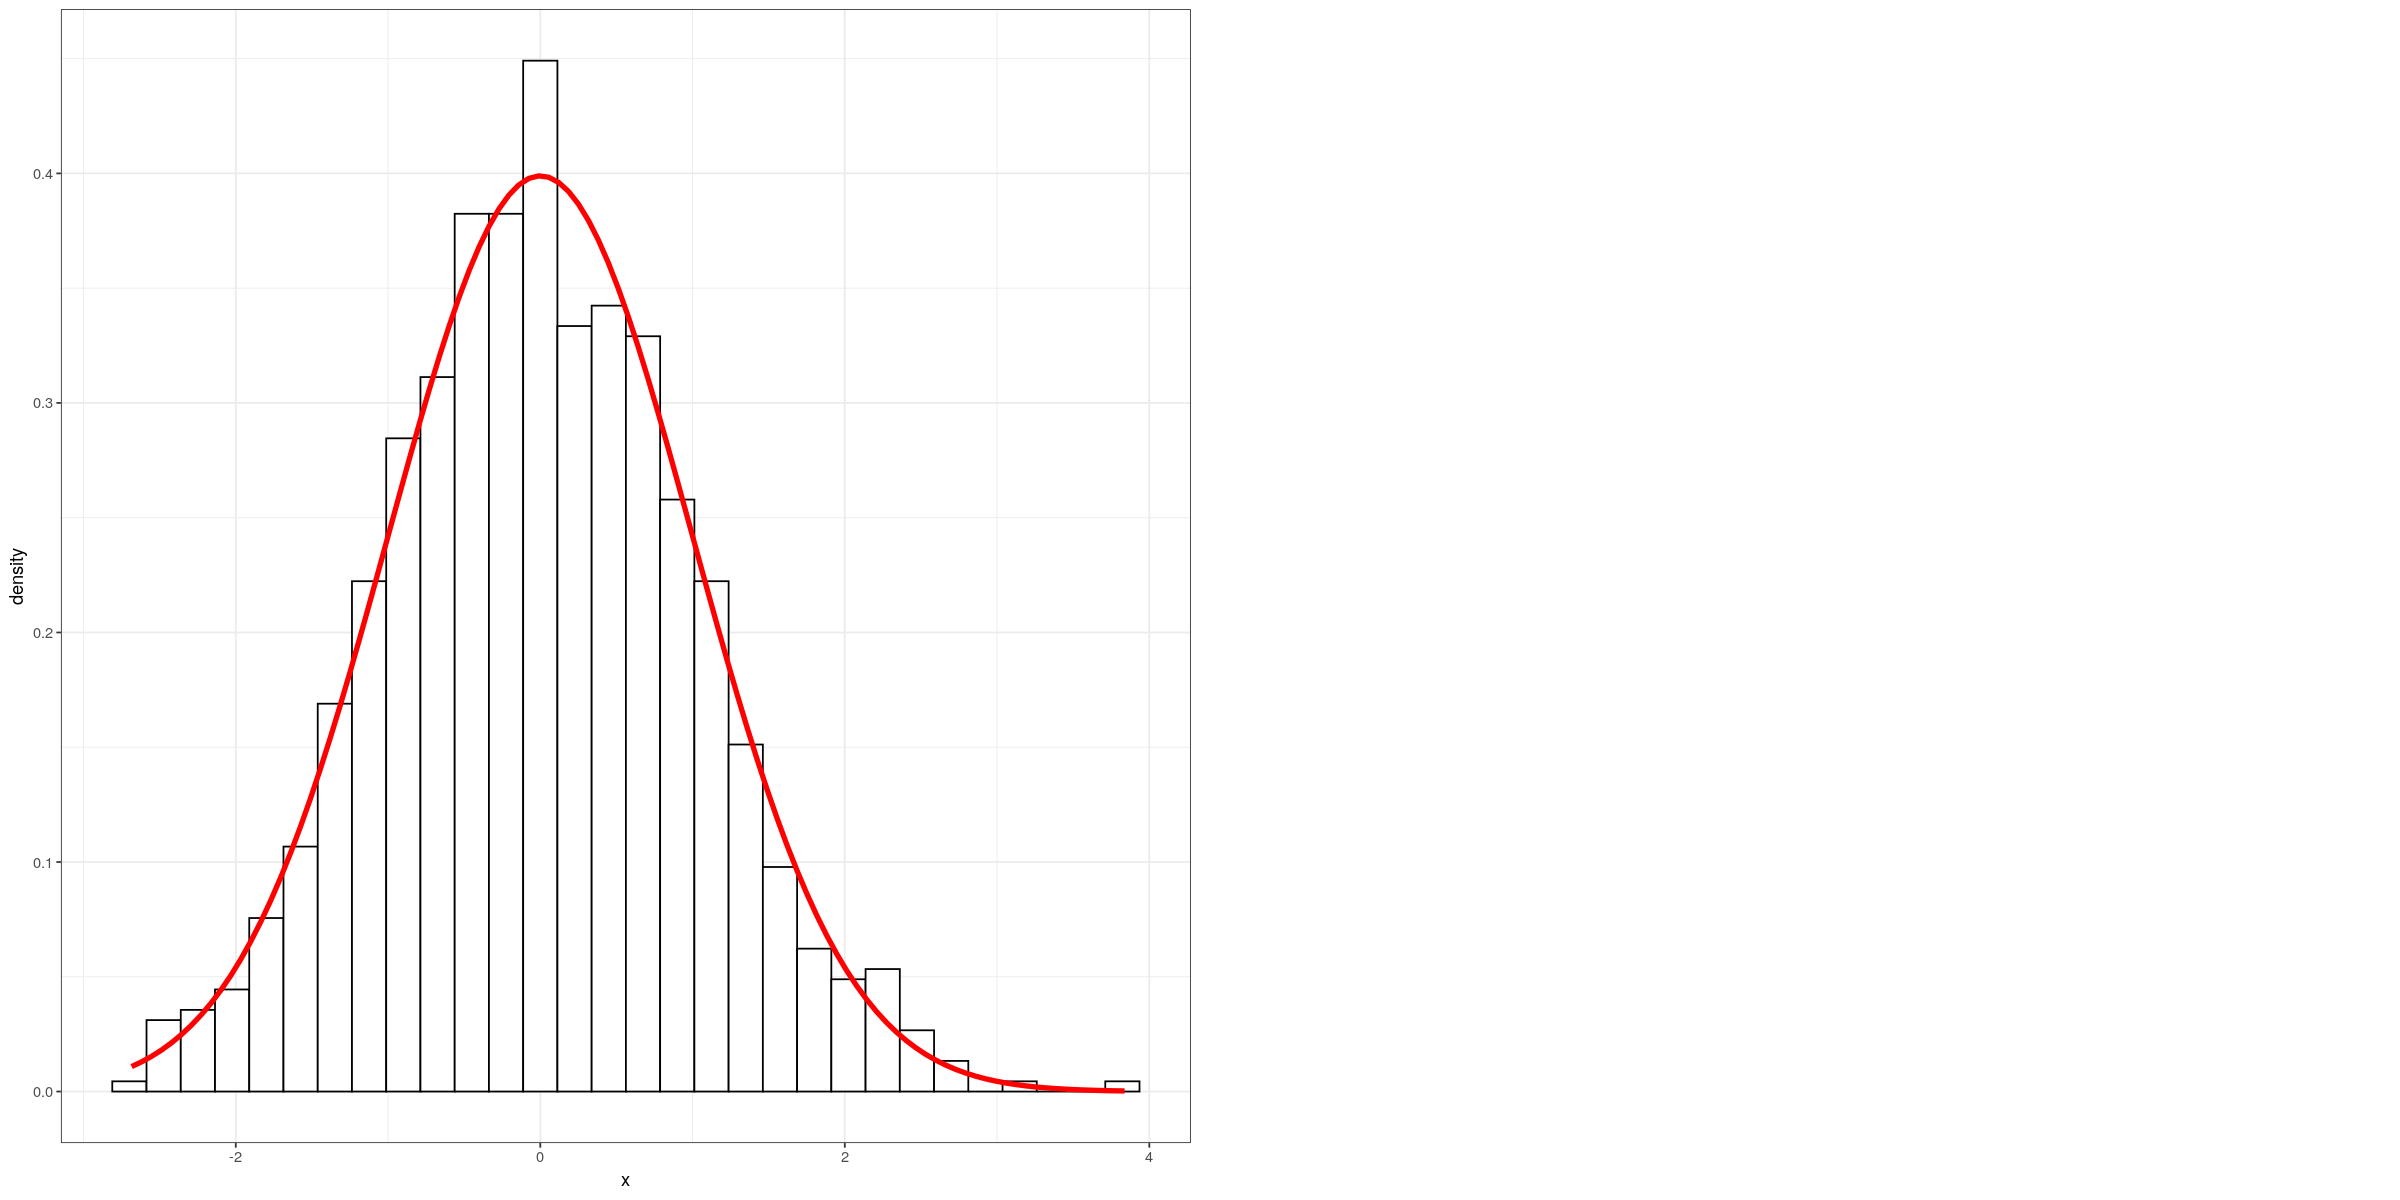

In [64]:
hists <- ggplot(null_norms, aes(x = x)) +
        geom_histogram(aes(y = ..density..),
                       color = 'black',
                       fill="white") +
        stat_function(fun = dnorm, 
                      colour = "red",
                      size = 1.5) + 
        theme_bw()
                
grid.arrange(hists,
            ncol = 2, nrow = 1)

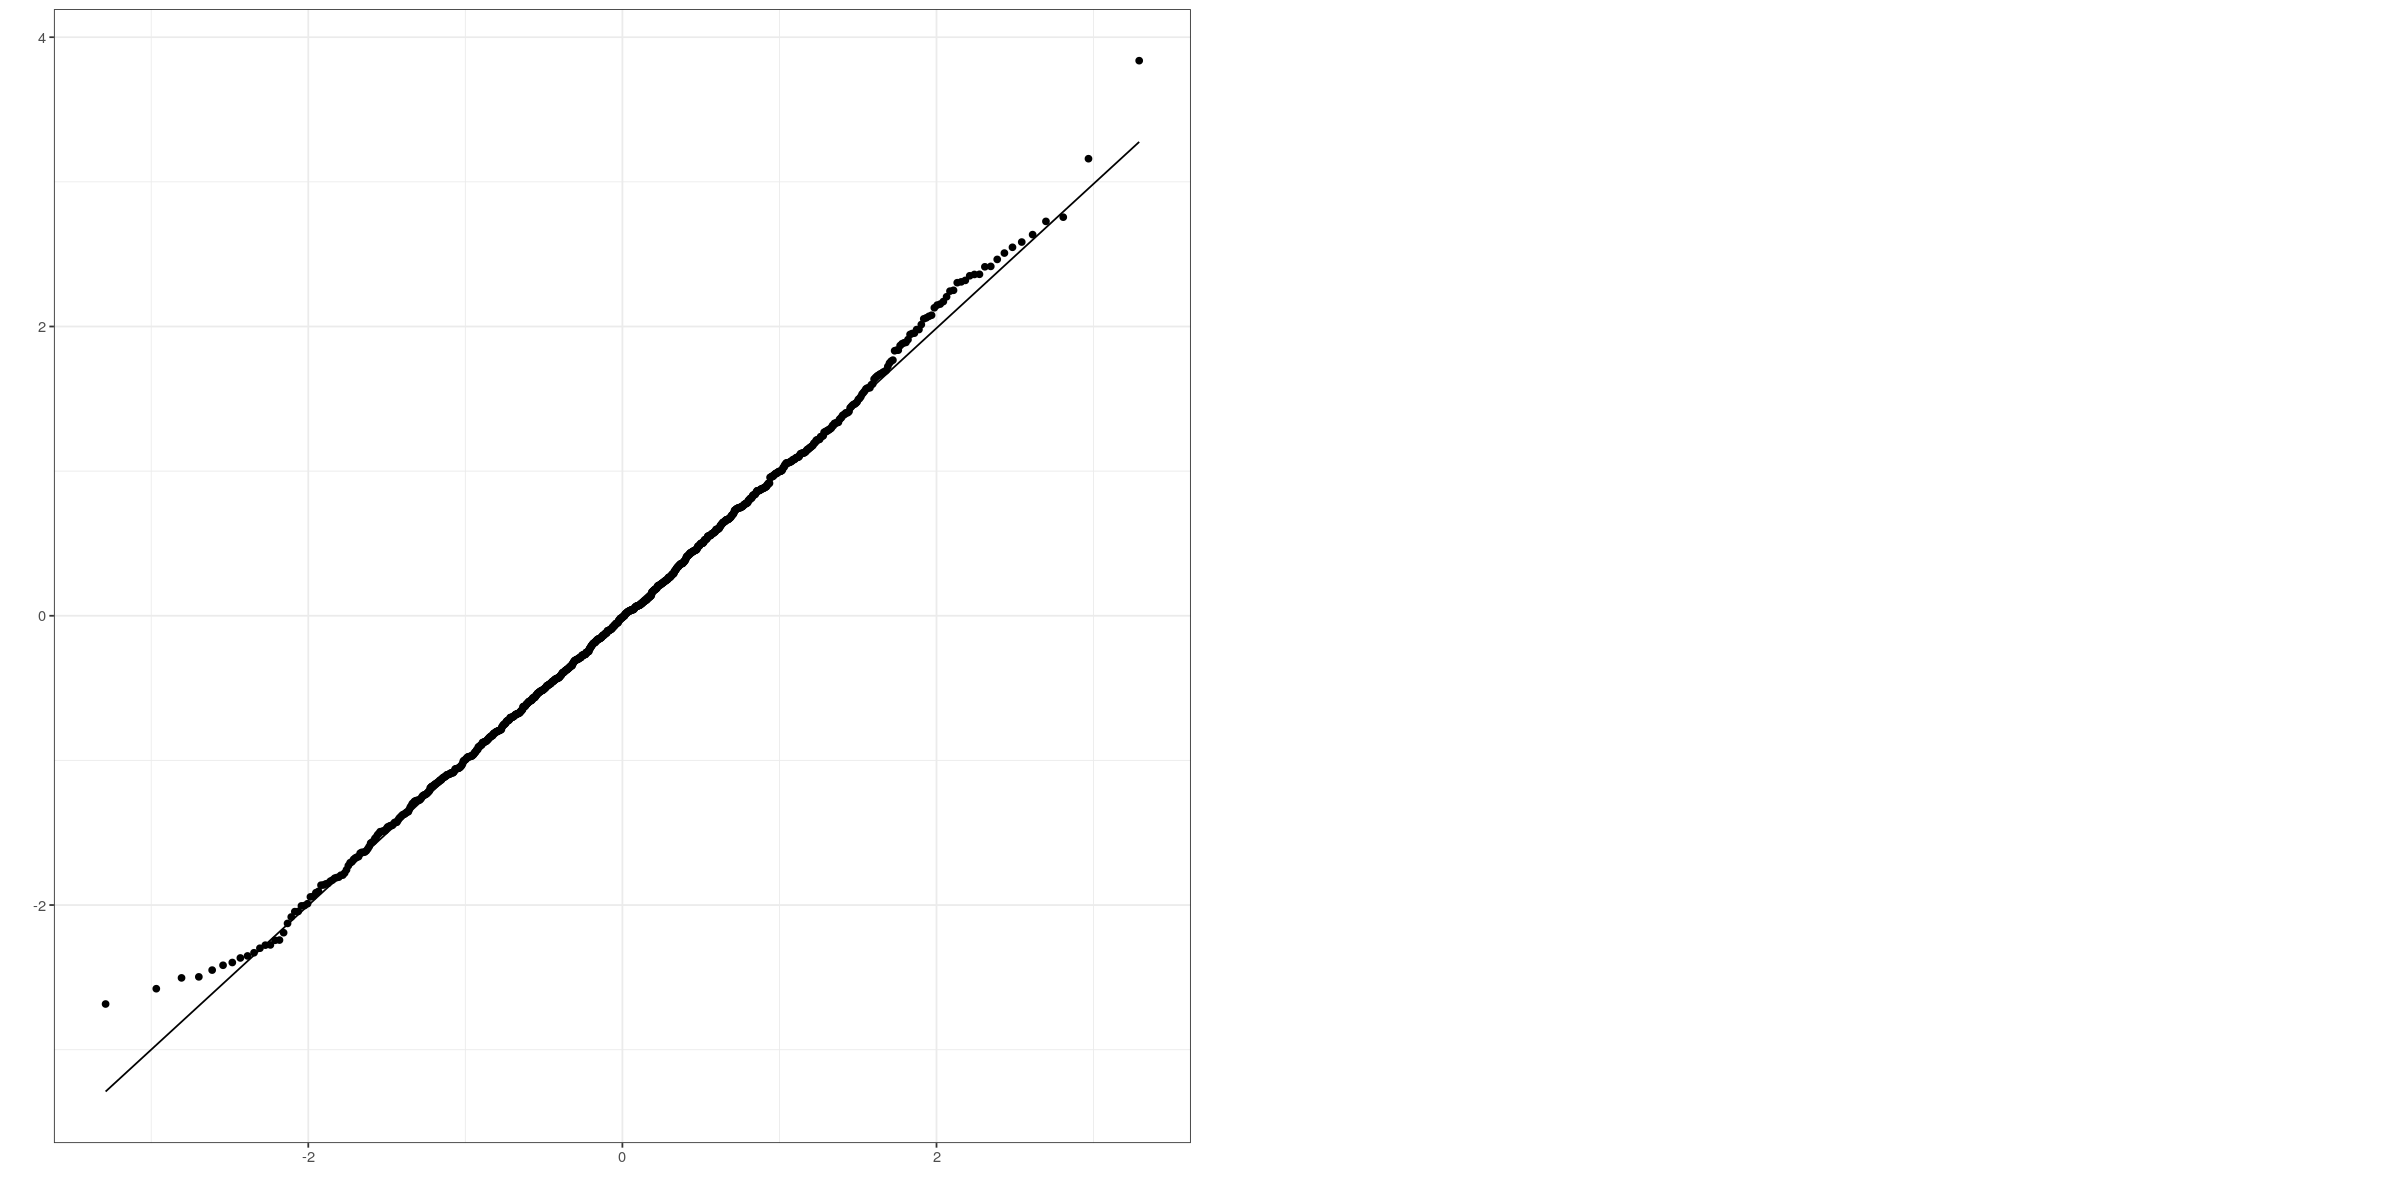

In [65]:
qplots <-  qplot(sample = x, data = null_norms) + 
                    stat_qq_line() +
                    theme_bw()
                 
grid.arrange(qplots,
            ncol = 2, nrow = 1)

### Goodness of fit tests

Finally, we discuss how suitable the test statistic is from the point of view of goodness-of-fit tests. When evaluated at the null model, the actual type 1 error is close to the nominal 5 \% level, as we would expect from the Gaussian approximation. However, relying only on the network-based statistics, it is difficult to detect subtle deviations from the null hypothesis of the Poisson process. Indeed, the test powers for the Matérn-cluster and Strauss process are 6.0\% and 8.3\%, respectively.

In [66]:
alpha <- .05
pps_list <- list(ppps_val, mcps, strs)

do.call(rbind.data.frame,
     lapply(pps_list,
                                  function(pp_list) sum(
                                      mclapply(pp_list, 
                                               function(pp) p_val(pp, 
                                                                  function(X) mean(tda0_net(X)$trans),
                                                                  null_means, 
                                                                  null_sds),
                                               mc.cores = 36
                                              ) < alpha) 
                                  )
       )

c.54L..60L..83L.
<int>
54
60
83
